Importing Libraries

First you must import all of the libraries that we are going to be using. The end of this is for connecting this notebook to your GPU so that it can train much quicker.

In [4]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
from collections import deque
from copy import deepcopy
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output

#connecting to the gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print("Using device:", device)
if device.type == "cuda":
    print("CUDA device name:", torch.cuda.get_device_name(0))

True
Using device: cuda
CUDA device name: NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [6]:
def to_device(tensor):
    return tensor.to(device)

Variables that Allow for easy modification of training rewards

In [7]:
#first define any values for rewards that can be easily modified for training
WON_GAME = 10 #reward for winning
LOST_GAME = -10 #penalty for losing
DRAW_GAME = 0 #reward for drawing
BLOCK_WIN = 3 #reward for blocking an opponent's three in a row
MISS_BLOCK = -3 #penalty for opponent having 3 in a row and you missed it
MISS_WIN = -3 #penalty for missing a move that would have resulted in a win
ONE_THREE = 2 #reward for making a three in a row
TWO_THREE = 4 #reward for making two three in a row in one move
MADE_MOVE = 0 #penalty for every move made, could encourage making more decisive moves

Class for the Connect 4 Environment in Which the models will train within

In [9]:
class Connect4Env:
    #initiallizes the board to 6 rows and 7 columns
    def __init__(self):
        self.rows = 6
        self.cols = 7
        self.reset()

    #creates the board by first initializing it all to zeros
    #also sets the starting player to the first model for when a game is reset
    def reset(self):
        self.board = np.zeros((self.rows, self.cols), dtype=int)
        self.current_player = 1
        self.last_move = None
        return self._get_obs()

    #stacks board into two layers, one for each model, one model handles the -1 board one model hands the 1 board
    def _get_obs(self):
        p1_board = (self.board == 1).astype(np.float32)
        p2_board = (self.board == -1).astype(np.float32)
        return np.stack([p1_board, p2_board], axis=0) if self.current_player == 1 else np.stack([p2_board, p1_board], axis=0)

    #determines which actions are valid as the top row will be empty in that column
    def valid_actions(self):
        return [c for c in range(self.cols) if self.board[0, c] == 0]

    #cused to make an action for a model
    def step(self, action):
        #checks if the action was valid, if not punishes the model
        if action not in self.valid_actions():
            return self._get_obs(), -10, True, {}

        #moves the piece from the bottom of the board up in order to place it when there is an empty spot
        for r in range(self.rows - 1, -1, -1):
            if self.board[r, action] == 0:
                self.board[r, action] = self.current_player
                self.last_move = (r, action)
                break

        #checks if that move resulted in the model winning, gives a reward
        if self._check_winner(self.current_player, self.last_move):
            #print(f"won {WON_GAME}")
            return self._get_obs(), WON_GAME, True, {}

        #checks for a draw if there are no valid actions left, if so gives a reward
        if len(self.valid_actions()) == 0:
            #updates metrics for trackign information
            metrics['draws'] += 1

            # Calculate the win ratio for Player 1
            total_games = metrics['p1_wins'] + metrics['p2_wins'] + metrics['draws']
            p1_ratio = metrics['p1_wins'] / total_games if total_games > 0 else 0.0
            p2_ratio = metrics['p2_wins'] / total_games if total_games > 0 else 0.0
            draw_ratio = metrics['draws'] / total_games if total_games > 0 else 0.0

            # Log the stats
            metrics.setdefault('p1_win_ratio', []).append(p1_ratio)
            metrics.setdefault('p2_win_ratio', []).append(p2_ratio)
            metrics.setdefault('draw_ratio', []).append(draw_ratio)
            #print(f"draw {DRAW_GAME}")
            return self._get_obs(), DRAW_GAME, True, {}

        #switches what player is currently playing and gives a reward for a move being made
        self.current_player *= -1
        #print(f"other move {MADE_MOVE}")
        return self._get_obs(), MADE_MOVE, False, {}

    #checks if the last move caused there to be a winner
    def _check_winner(self, player, last_move):
        if last_move is None:
            return False
        r, c = last_move
        directions = [(1, 0), (0, 1), (1, 1), (1, -1)]
        for dr, dc in directions:
            count = 1
            for d in [-1, 1]:
                nr, nc = r + d * dr, c + d * dc
                while 0 <= nr < self.rows and 0 <= nc < self.cols and self.board[nr, nc] == player:
                    count += 1
                    if count >= 4:
                        #updates metrics for trackign information
                        if player == 1:
                            metrics['p1_wins'] += 1
                        elif player == -1:
                            metrics['p2_wins'] += 1

                        # Calculate the win ratio for Player 1
                        total_games = metrics['p1_wins'] + metrics['p2_wins'] + metrics['draws']
                        p1_ratio = metrics['p1_wins'] / total_games if total_games > 0 else 0.0
                        p2_ratio = metrics['p2_wins'] / total_games if total_games > 0 else 0.0
                        draw_ratio = metrics['draws'] / total_games if total_games > 0 else 0.0

                        # Log the stats
                        metrics.setdefault('p1_win_ratio', []).append(p1_ratio)
                        metrics.setdefault('p2_win_ratio', []).append(p2_ratio)
                        metrics.setdefault('draw_ratio', []).append(draw_ratio)
                        return True
                    nr += d * dr
                    nc += d * dc
        return False

    #a static version to check if there is a winner in a current state of the board
    @staticmethod
    def _check_winner_static(board, player):
        for r in range(6):
            for c in range(4):
                if all(board[r, c+i] == player for i in range(4)):
                    return True
        for c in range(7):
            for r in range(3):
                if all(board[r+i, c] == player for i in range(4)):
                    return True
        for r in range(3):
            for c in range(4):
                if all(board[r+i, c+i] == player for i in range(4)):
                    return True
        for r in range(3):
            for c in range(3, 7):
                if all(board[r+i, c-i] == player for i in range(4)):
                    return True
        return False



We must make a method to analyze the move that was made by the player, and give a reward accordingly.

In [69]:
#function that is first called that looks at the move and determines what reward it deserves
def analyze_move(prev_board, new_board, current_player, valid_actions, last_move):
    reward = 0.0

    #sees if the move made just created any three in a rows that are threats for the opponent
    threats = find_threats_from_move(new_board, current_player, last_move)
    if len(threats) >= 2:
        #print(f"two three {TWO_THREE}")
        reward += TWO_THREE
    elif len(threats) == 1:
        #print(f"one three {ONE_THREE}")
        reward += ONE_THREE

    #loops through the board and sees if there was a winning move but it missed it
    for action in valid_actions:
        temp = new_board.copy()
        for r in range(5, -1, -1):
            if temp[r, action] == 0:
                temp[r, action] = current_player
                break
        if Connect4Env._check_winner_static(temp, current_player):
            #print(f"missed win {MISS_WIN}")
            reward += MISS_WIN
            break

    #simulates the opponent making a move on the previous board, if the opponent could have won in a position, but you blocked it, then you get a reward
    opponent = -current_player
    opponent_winning_move_exists = False
    blocked = False
    
    for action in valid_actions:
        temp = prev_board.copy()
        for r in range(5, -1, -1):
            if temp[r, action] == 0:
                temp[r, action] = opponent
                break
        # Check if there was actually a winning move for the opponent
        if Connect4Env._check_winner_static(temp, opponent):
            opponent_winning_move_exists = True
            temp2 = new_board.copy()
            for r in range(5, -1, -1):
                if temp2[r, action] == 0:
                    temp2[r, action] = opponent
                    break
            if not Connect4Env._check_winner_static(temp2, opponent):
                #print(f"block win {BLOCK_WIN}")
                reward += BLOCK_WIN
                blocked = True
                break
    
    # Only apply MISS_BLOCK if there was a win to block
    if opponent_winning_move_exists and not blocked:
        #print(f"missed block {MISS_BLOCK}")
        reward += MISS_BLOCK

    return reward

In [70]:
#function from analyze move for finding if you made any three in a rows
def find_threats_from_move(board, player, move):
    r, c = move
    rows, cols = 6, 7
    threats = set()
    directions = [(0,1), (1,0), (1,1), (1,-1)]

    for dr, dc in directions:
        for offset in range(-3, 1):
            segment = []
            positions = []
            for i in range(4):
                nr = r + (offset + i) * dr
                nc = c + (offset + i) * dc
                if 0 <= nr < rows and 0 <= nc < cols:
                    segment.append(board[nr, nc])
                    positions.append((nr, nc))
            if len(segment) == 4 and segment.count(player) == 3 and segment.count(0) == 1:
                idx = segment.index(0)
                er, ec = positions[idx]
                if er == rows - 1 or board[er + 1, ec] != 0:
                    threats.add(ec)
    return threats

A Deep Q-Network Model to define the layers of the neural network, the more complex it is, the more information it can store, but it could take longer to train

In [71]:
class DQN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=4, stride=2, padding=1),  # Larger stride to reduce faster
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Smaller convolution
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)  # Pool earlier
        )

        self.fc = nn.Sequential(
            nn.Linear(128, 64),  # Adjusted for smaller size
            nn.ReLU(),
            nn.Linear(64, 7)
        )

        self.init_weights()

    #sets initial weights of the model to 0
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
        #boosts the middle of the board at the start of the game as it would be an ideal position
        with torch.no_grad():
            self.fc[-1].bias[3] = 0.5

    #defines the forward pass for the model, first it puts it through the convolutional layers, and then the fully connect layers
    def forward(self, x, valid_moves_mask=None):
        x = self.conv_layers(x)
        x = x.flatten(1)
        x = self.fc(x)

        if valid_moves_mask is not None:
            x = x.masked_fill(~valid_moves_mask, float('-inf'))
        return x

Prioritized Replay Buffer, used to prioritiuze important experiences which had higher errors during training

In [72]:
class PrioritizedReplayBuffer:
    #initializes the buffer with a set number of experiences it can remember and a list of prioritizes to determine which is most important
    def __init__(self, capacity=10000, alpha=0.6):
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)
        self.alpha = alpha

    #adds an experience to the buffer
    def push(self, transition, error):
        self.buffer.append(transition)
        self.priorities.append((abs(error) + 1e-5) ** self.alpha)

    #takes a set number of samples from the buffer to use to make a decision in training
    def sample(self, batch_size):
        total_priority = sum(self.priorities)
        probabilities = [p / total_priority for p in self.priorities]
        indices = random.choices(range(len(self.buffer)), k=batch_size, weights=probabilities)
        samples = [self.buffer[idx] for idx in indices]
        return samples

    def __len__(self):
        return len(self.buffer)

In [44]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

Selecting Action

In [74]:
#takes in the current model, state of the board, epsilon, and valid actions, then determines what action to make
def select_action(model, state, epsilon, valid_actions):
    #determines whether to explore a new move or use the agents current knowledge
    if random.random() < epsilon:
        return random.choice(valid_actions)
    else:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).view(1, 2, 6, 7).to(device)
            q_values = model(state_tensor).squeeze()
            q_values[[i for i in range(7) if i not in valid_actions]] = -float('inf')
            return torch.argmax(q_values).item()

In [10]:
def plot_training_metrics(metrics):
    # Episode Rewards for Player 1
    plt.figure(figsize=(8, 5))
    plt.plot(metrics['episode_rewards_p1'], label='Player 1')
    plt.title('Episode Rewards - Player 1')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Episode Rewards for Player 2
    plt.figure(figsize=(8, 5))
    plt.plot(metrics['episode_rewards_p2'], label='Player 2')
    plt.title('Episode Rewards - Player 2')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Epsilon Decay
    plt.figure(figsize=(8, 5))
    plt.plot(metrics['epsilon_values'])
    plt.title('Epsilon Decay Over Time')
    plt.grid(True)
    plt.show()
    
     # Plot TD Errors
    if len(metrics['errors']) > 0:
        window = min(100, len(metrics['errors']))
        smooth_td = np.convolve(metrics['errors'], np.ones(window) / window, mode='valid')
        plt.figure(figsize=(8, 5))
        plt.plot(smooth_td, label='TD Error (Smoothed)')
        plt.title('Temporal Difference Error Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plot Training Loss
    if len(metrics['losses']) > 0:
        window = min(100, len(metrics['losses']))
        smooth_loss = np.convolve(metrics['losses'], np.ones(window) / window, mode='valid')
        plt.figure(figsize=(8, 5))
        plt.plot(smooth_loss, label='Training Loss (Smoothed)')
        plt.title('Training Loss Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # Win Ratios Over Time
    if len(metrics['p1_win_ratio']) > 0:
        plt.figure(figsize=(8, 5))
        plt.plot(metrics['p1_win_ratio'], label='Player 1 Win Ratio')
        plt.plot(metrics['p2_win_ratio'], label='Player 2 Win Ratio')
        plt.plot(metrics['draw_ratio'], label='Draw Ratio')
        plt.title('Win Ratios Over Time')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Column Usage
    norm_usage = metrics['column_usage'] / np.sum(metrics['column_usage'])
    plt.figure(figsize=(8, 5))
    plt.bar(range(len(norm_usage)), norm_usage)
    plt.title('Normalized Column Usage')
    plt.grid(True)
    plt.show()
    
    # Average Game Length (Smoothed)
    if len(metrics['avg_game_length']) > 0:
        window = min(100, len(metrics['avg_game_length']))
        smooth = np.convolve(metrics['avg_game_length'], np.ones(window) / window, mode='valid')
        plt.figure(figsize=(8, 5))
        plt.plot(smooth)
        plt.title('Average Game Length (Smoothed)')
        plt.grid(True)
        plt.show()

Training Loop

In [ ]:
#defines the metrics and resets them for viewing success
metrics = {
        'episode_rewards_p1': [], 'episode_rewards_p2': [], 'epsilon_values': [],
        'losses': [], 'errors': [], 'p1_wins': 0, 'p2_wins': 0, 'draws': 0, 'p1_win_ratio': [], 'p2_win_ratio': [], 'draw_ratio': [],
        'column_usage': np.zeros(7), 'avg_game_length': []
    }

def train_self_play(episodes=50000, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.9995, gamma=0.99, batch_size=64, update_target_every=10):
    #defines the environment, models, optimizers, and buffers
    env = Connect4Env()
    model1 = DQN().to(device)
    model2 = DQN().to(device)

    target_model1 = DQN().to(device)
    target_model2 = DQN().to(device)

    target_model1.load_state_dict(model1.state_dict())
    target_model2.load_state_dict(model2.state_dict())

    optimizer1 = optim.Adam(model1.parameters(), lr=5e-4) 
    optimizer2 = optim.Adam(model2.parameters(), lr=5e-4)

    buffer1 = ReplayBuffer()
    buffer2 = ReplayBuffer()

    #loops for the set number of episodes to train over that many games
    for episode in range(episodes):
        game_length = 0
        state = env.reset()
        done = False
        reward_p1 = 0
        reward_p2 = 0
        last_moves = {1: None, -1: None}

        while not done:
            game_length += 1
            current_player = env.current_player
            model = model1 if current_player == 1 else model2
            buffer = buffer1 if current_player == 1 else buffer2
            optimizer = optimizer1 if current_player == 1 else optimizer2
            target_model = target_model1 if current_player == 1 else target_model2

            valid_actions = env.valid_actions()
            action = select_action(model, state, epsilon, valid_actions)

            prev_board = env.board.copy()
            next_state, reward, done, _ = env.step(action)
            if not done:
                reward += analyze_move(prev_board, env.board, current_player, env.valid_actions(), env.last_move)

            # Calculate TD Error for Prioritized Replay
            error = abs(reward + gamma * torch.max(target_model(torch.tensor(next_state, dtype=torch.float32)
                        .view(1, 2, 6, 7).to(device)).detach()) - model(torch.tensor(state, dtype=torch.float32)
                        .view(1, 2, 6, 7).to(device))[0, action])
            metrics['errors'].append(error.item())
            
            last_moves[current_player] = (np.array(state, copy=True), action, np.array(next_state, copy=True))
            buffer.push((np.array(state, copy=True), action, reward, np.array(next_state, copy=True), done))
            state = next_state

            metrics['column_usage'][action] += 1

            if current_player == 1:
                reward_p1 += reward
            else:
                reward_p2 += reward

            if done and reward >= 1:
                losing_player = -current_player
                if last_moves[losing_player] is not None:
                    s, a, ns = last_moves[losing_player]
                    opp_buffer = buffer1 if losing_player == 1 else buffer2
                    error = abs(reward + gamma * torch.max(target_model(torch.tensor(next_state, dtype=torch.float32)
                        .view(1, 2, 6, 7).to(device)).detach()) - model(torch.tensor(state, dtype=torch.float32)
                        .view(1, 2, 6, 7).to(device))[0, action])
                    opp_buffer.push((s, a, -1.0, ns, True))
                    if losing_player == 1:
                        #print(f"lost {losing_player} {LOST_GAME}")
                        reward_p1 += LOST_GAME
                    else:
                        #print(f"lost {losing_player} {LOST_GAME}")
                        reward_p2 += LOST_GAME

            """print("Replay Buffer Content (First 5):")
            for idx, sample in enumerate(buffer.buffer):
                if idx < 5:
                    print(sample)
                else:
                    break"""
            if len(buffer) >= batch_size:
                transitions = buffer.sample(batch_size)
                states, actions, rewards, next_states, dones = zip(*transitions)
                states = torch.tensor(np.stack(states), dtype=torch.float32).to(device)
                actions = torch.tensor(actions).unsqueeze(1).to(device)
                rewards = torch.tensor(rewards).unsqueeze(1).to(device)
                next_states = torch.tensor(np.stack(next_states), dtype=torch.float32).to(device)
                dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)

                q_values = model(states).gather(1, actions)
                with torch.no_grad():
                    max_next_q = target_model(next_states).max(1)[0].unsqueeze(1)
                    target_q = rewards + gamma * max_next_q * (1 - dones)

                loss = F.mse_loss(q_values, target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                metrics['losses'].append(loss.item())

        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

        if episode % update_target_every == 0:
            target_model1.load_state_dict(model1.state_dict())
            target_model2.load_state_dict(model2.state_dict())
        
        if episode % 100 == 0:
            print(f"Episode {episode}, P1 reward: {reward_p1:.2f}, P2 reward: {reward_p2:.2f}, Epsilon: {epsilon:.3f}")
            # --- Print a sample game between models ---
            temp_env = Connect4Env()
            game_state = temp_env.reset()
            game_over = False
            print("\nSample Game:")
            while not game_over:
                player = temp_env.current_player
                model = model1 if player == 1 else model2
                valid_actions = temp_env.valid_actions()
                action = select_action(model, game_state, 0.0, valid_actions)
                game_state, _, game_over, _ = temp_env.step(action)
                print(temp_env.board)
                print("Player", player, "chose column", action)
                print("---")

        if episode % 10000 == 0:
            torch.save(model1.state_dict(), f"4connect4_model1_{episode}.pth")
            torch.save(model2.state_dict(), f"4connect4_model2_{episode}.pth")

        metrics['episode_rewards_p1'].append(reward_p1)
        metrics['episode_rewards_p2'].append(reward_p2)
        metrics['epsilon_values'].append(epsilon)
        metrics['avg_game_length'].append(game_length)
    
    torch.save(model1.state_dict(), "4connect4_model1_final.pth")
    torch.save(model2.state_dict(), "4connect4_model2_final.pth")
    return model1, model2


Train It

In [79]:
if 'ui' in globals():
    del ui
clear_output(wait=True)
trained_model1, trained_model2 = train_self_play(episodes=500000,epsilon_decay=0.9999,epsilon_min=0.05,batch_size=128)
plot_training_metrics(metrics)

Episode 0, P1 reward: 6.00, P2 reward: -15.00, Epsilon: 1.000

Sample Game:
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]]
Player 1 chose column 3
---
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0]
 [ 0  0  0  1  0  0  0]]
Player -1 chose column 3
---
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0  0 -1  0  0  0]
 [ 0  0  0  1  0  0  0]]
Player 1 chose column 3
---
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0 -1  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0  0 -1  0  0  0]
 [ 0  0  0  1  0  0  0]]
Player -1 chose column 3
---
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0  0 -1  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0  0 -1  0  0  0]
 [ 0  0  0  1  0  0  0]]
Player 1 chose column 3
---
[[ 0  0  0 -1  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0  0 -1  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 

KeyboardInterrupt: 

In [1]:
import pickle
plot_training_metrics(metrics)
with open('metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)

NameError: name 'plot_training_metrics' is not defined

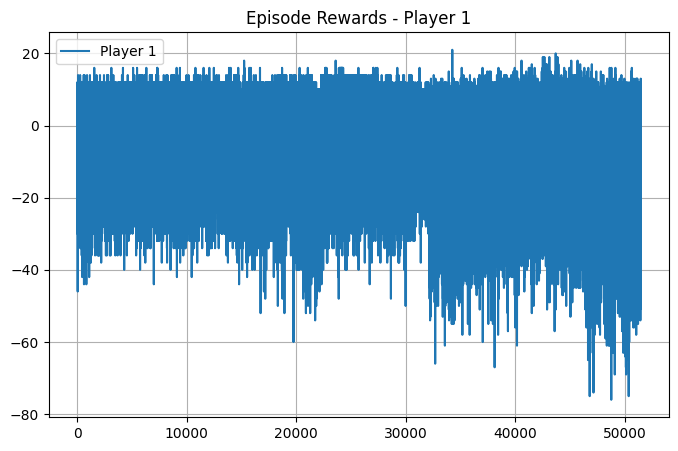

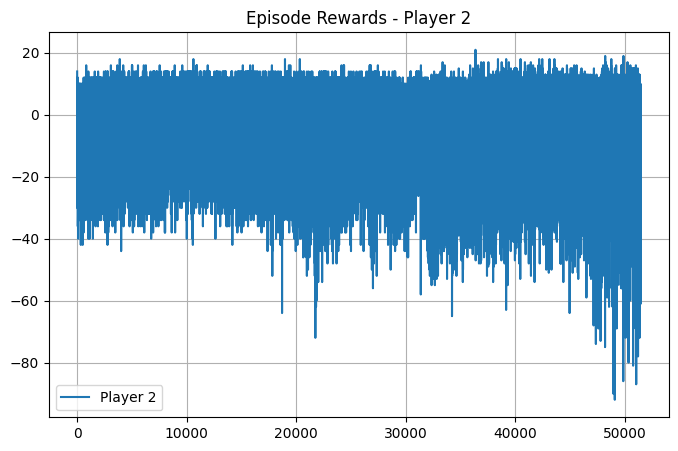

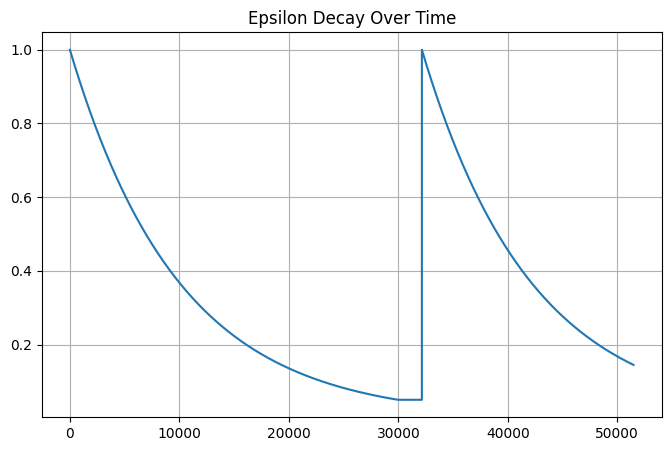

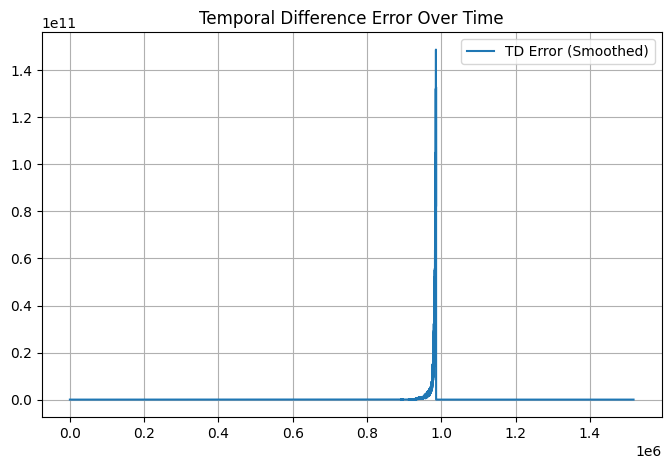

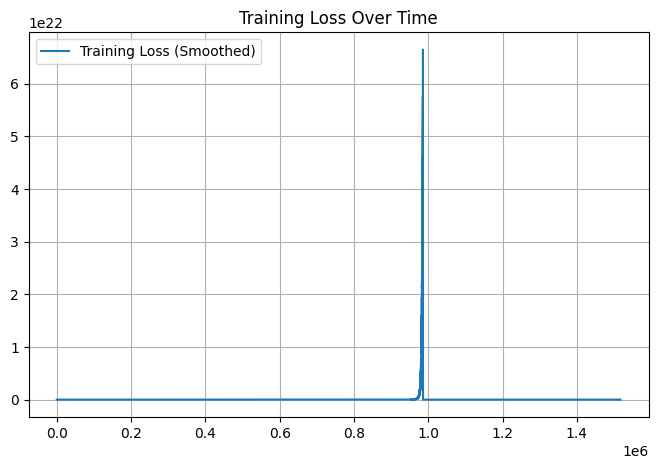

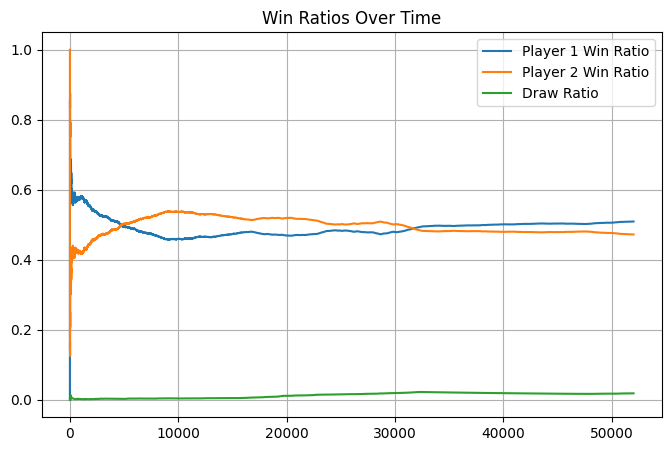

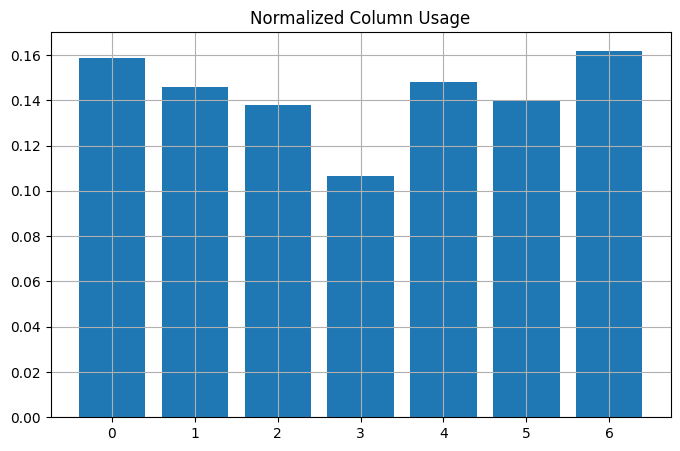

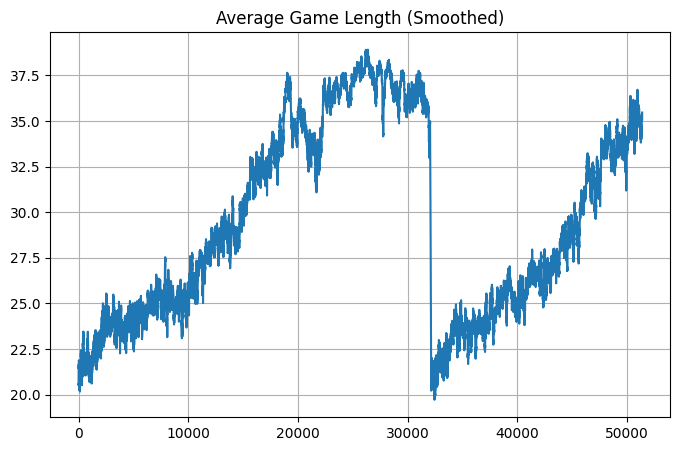

In [11]:
import pickle

with open('metrics.pkl', 'rb') as f:
    metrics = pickle.load(f)

# Now you can plot again:
plot_training_metrics(metrics)

In [8]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

In [9]:
save_model(trained_model)

NameError: name 'trained_model' is not defined

Load Weights

In [12]:
def load_trained_model(path="connect4_model_weights.pth"):
    model = DQN().to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()  # Set to evaluation mode
    print(f"Loaded model from {path}")
    return model

In [11]:
trained_model = load_trained_model(path="connect4_dqn_ep10000.pth")

Loaded model from connect4_dqn_ep10000.pth
